In [2]:
import requests

In [5]:
r = requests.get("https://raw.githubusercontent.com/tesseract-ocr/tessdata/4.00/ind.traineddata", stream = True)  
  
# Writing data to file to avoid path isuues
with open("ind.traineddata", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

In [6]:
! apt install tesseract-ocr libtesseract-dev libmagickwand-dev
from IPython.display import HTML, clear_output
clear_output()

In [7]:
! pip install pytesseract wand opencv-python
clear_output()

In [8]:
from PIL import Image
import pytesseract
import cv2
import numpy as np
from pytesseract import Output
import re

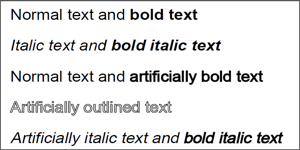

In [9]:
# Reading image form url
image = Image.open(requests.get('https://i.stack.imgur.com/pbIdS.png', stream=True).raw)
image = image.resize((300,150))
image.save('sample.png')
image

In [10]:
custom_config = r'-l eng --oem 3 --psm 6' 
text = pytesseract.image_to_string(image,config=custom_config)
print(text)

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.